# TP4 - Improve the Metropolis-Hastings algorithm


*Louis Martinez*

### Imports and utility functions 

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invgamma, norm

import random
np.random.seed(0)
random.seed(0)

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Utility functions for the whole notebook
def cross_corr(x, y, max_lag=50):
    assert len(x) == len(y)
    x = (x - x.mean()) / x.std()
    y = (y - y.mean()) / y.std()
    n = len(x)
    corr = np.correlate(x, y, mode='full') / n # normalized 
    return corr[n-1:n-1+max_lag]

def scatter(x, y, alpha=0.3, s=5, title=None, show=True):
    plt.figure()
    if title: plt.title(title)
    plt.scatter(x, y, alpha=alpha, s=s)
    if show: plt.show()

def plot_dist(pdf, xrange, yrange, n_levels=15, sidebar=True, title=None, figsize=(8,5), cmap='Reds'):
    plt.figure(figsize=figsize)
    x, y = np.meshgrid(xrange, yrange)
    pos = np.dstack((x, y))
    z = np.apply_along_axis(pdf, 2, pos)
    print(z.shape)
    levels = np.linspace(0, z.max(), n_levels)
    CS = plt.contourf(x, y, z, levels=levels, cmap=cmap)
    if sidebar: plt.colorbar(CS)
    if title: plt.title(title)
    plt.show()

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

Distribution of interest:

$$(x, y) \mapsto \pi(x, y) \propto \exp\left(-\frac{x^2}{a^2}-y^2-\frac{1}{4}\left(\frac{x^2}{a^2}-y^2\right)^2\right)$$

### 1.A - Metropolis-Hastings within Gibbs sampler

(100, 100)


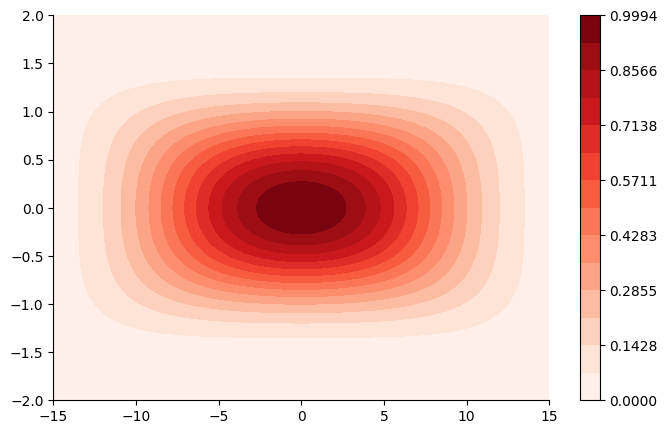

In [2]:
def log_pi(x, a=10):
    return -(x[0]/a)**2 - x[1]**2 - 0.25*((x[0]/a)**2-x[1]**2)**2

pi = lambda x: np.exp(log_pi(x))

plot_dist(pi,
          xrange=np.linspace(-15,15,100),
          yrange=np.linspace(-2, 2,100),
          sidebar=True
         )

#### 1. Implementation of the algorithm

In [3]:
def mhwg(log_pi, n_iter, sigma_prop):
    """
    Implementation of Metropolis-Hastings Within Gibbs in 2D
    """
    sigma_prop = np.array(sigma_prop)

    accepts = np.zeros(2)
    attemps = np.zeros(2)
    
    x = np.zeros(2)
    current_log_pi = log_pi(x)
    samples = np.zeros((n_iter, 2))
    mask = np.eye(2)
    
    for i in tqdm(range(n_iter)):
        k = np.random.randint(2)
        u = np.random.randn() * sigma_prop[k]
        x_proposal = x + mask[k] * u

        log_alpha = log_pi(x_proposal) - current_log_pi
        if np.log(np.random.rand()) < log_alpha:
            x = x_proposal
            current_log_pi = log_pi(x)
            accepts[k] += 1
        attemps[k] += 1
        
        samples[i] = x

    acceptance_rates = accepts/attemps
    return samples, acceptance_rates

#### 2. Testing the algorithm with $a=10$ and $(\sigma_1,\sigma_2)=(3,3)$

100%|██████████| 2000/2000 [00:00<00:00, 57048.28it/s]

Acceptance rates: [0.85496957 0.26725838]


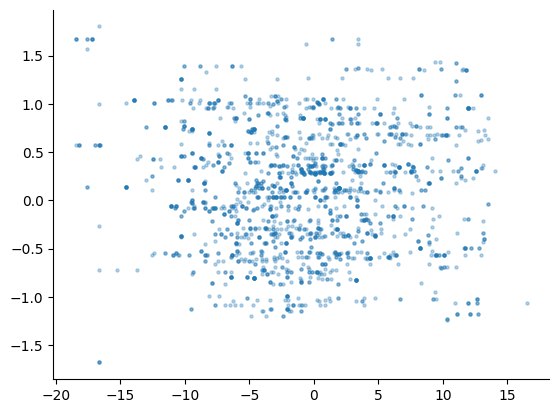

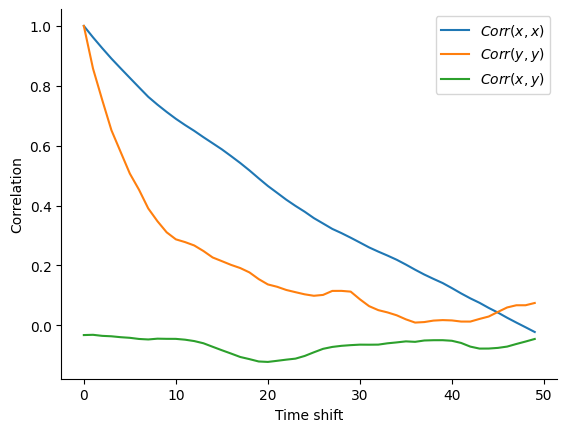

In [4]:
a = 10
x, a_rates = mhwg(log_pi, 
         n_iter=2000, 
         sigma_prop=[3,3]
        )
print(f'Acceptance rates: {a_rates}')
scatter(x[:,0], x[:,1], alpha=0.3)

plt.figure()
plt.plot(cross_corr(x[:,0], x[:,0]), label='$Corr(x,x)$')
plt.plot(cross_corr(x[:,1], x[:,1]), label='$Corr(y,y)$')
plt.plot(cross_corr(x[:,0], x[:,1]), label='$Corr(x,y)$')
plt.legend()
plt.xlabel('Time shift')
plt.ylabel('Correlation')
plt.show()

Given the current parameters, the algorithm works poorly. With a sufficiently small number of samples, we notice that they form horizontal lines, which don't correspond to anything with respect to the target distribution.

#### 3. Possible solutions

1. After having a look at the expression of the target distribution, we notice that $x$ and $y$ play symmetric roles up to the constant $a$. However, in the first situation, we used the same standard deviations to sample along $x$ and $y$ axes. **Rescaling $\sigma$ by $a$ for the $x$ axis** is enough to make the sampling procedure independent to $a$ (figures below).

2. Instead of choosing either $x$ or $y$ axes to move in the 2D plane from one point to another, we can **define a Gaussian** on the current point and propose a direction and distance with respect to this Gaussian. As a consequence, sampling become isotropic. 

100%|██████████| 2000/2000 [00:00<00:00, 70592.16it/s]

Acceptance rates: [0.27923387 0.25198413]


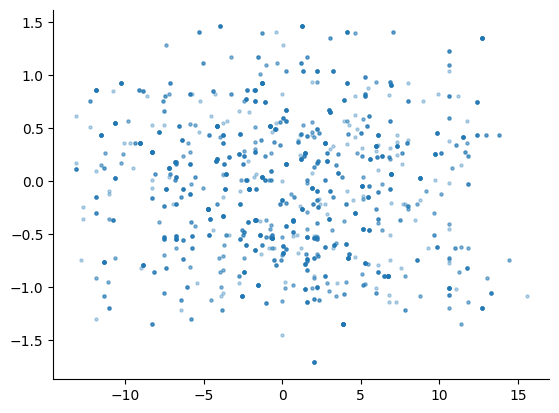

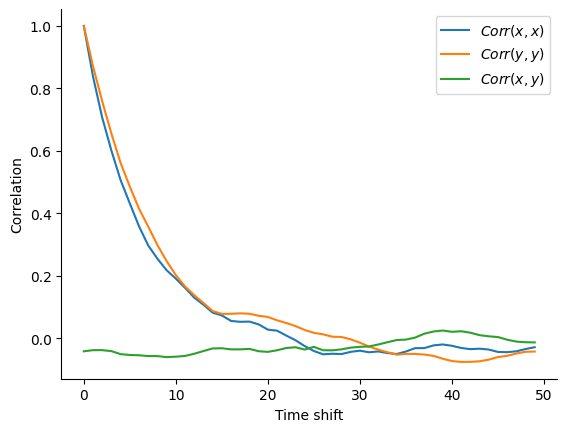

In [5]:
x, a_rates = mhwg(log_pi, 
         n_iter=2000, 
         sigma_prop=[a*3,3]
        )
print(f'Acceptance rates: {a_rates}')
scatter(x[:,0], x[:,1], alpha=0.3)

plt.figure()
plt.plot(cross_corr(x[:,0], x[:,0]), label='$Corr(x,x)$')
plt.plot(cross_corr(x[:,1], x[:,1]), label='$Corr(y,y)$')
plt.plot(cross_corr(x[:,0], x[:,1]), label='$Corr(x,y)$')
plt.legend()
plt.xlabel('Time shift')
plt.ylabel('Correlation')
plt.show()

**Observations**: Rescaling the standard deviation for the $x$ axis we notice that the auto-correlation of $x$ decereases with way faster than with the same std on each axis.

### 1.B - Adaptive Metropolis-Hastings within Gibbs sampler

#### 1. Implementation of the algorithm

In [6]:
def amhwg(log_pi, n_batches, batch_size, d):
    """
    Implementation of Adaptive Metropolis-Hastings Within Gibbs in 2D
    After each batch, we adapt the hyperparameters of the algorithm
    """
    x = np.random.randn(d)
    accepts = np.zeros((n_batches, d))
    current_log_pi = log_pi(x)

    samples = np.zeros((n_batches * batch_size, d))
    log_step_size = np.zeros((n_batches, d))

    mask = np.eye(d)
    for i in tqdm(range(n_batches)):

        for batch in range(batch_size):
            for k in range(d):
                u = np.random.randn() * np.exp(log_step_size[i-1, k]) # *1 initially
                x_proposal = x + mask[k]*u
                log_alpha = log_pi(x_proposal) -  current_log_pi
                if np.log(np.random.rand()) < log_alpha:
                    x = x_proposal
                    current_log_pi = log_pi(x)
                    accepts[i,k] += 1
            samples[i * batch_size + batch] = x
        accepts[i] /= batch_size

        delta = min(0.05, a/np.sqrt(i+1))
        for k in range(d):
            e = 2 * (accepts[i,k] > 0.24) - 1
            log_step_size[i,k] = log_step_size[i-1, k] + e * delta
    return samples, accepts, log_step_size

100%|██████████| 40/40 [00:00<00:00, 946.06it/s]


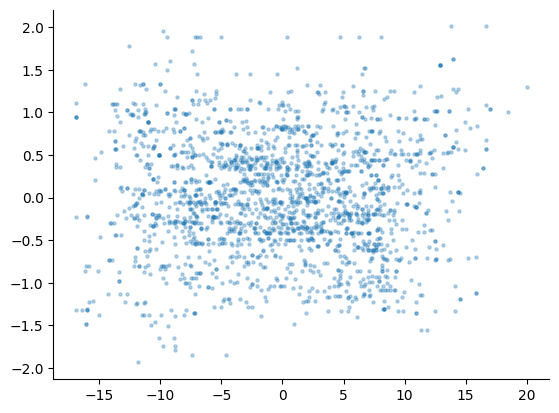

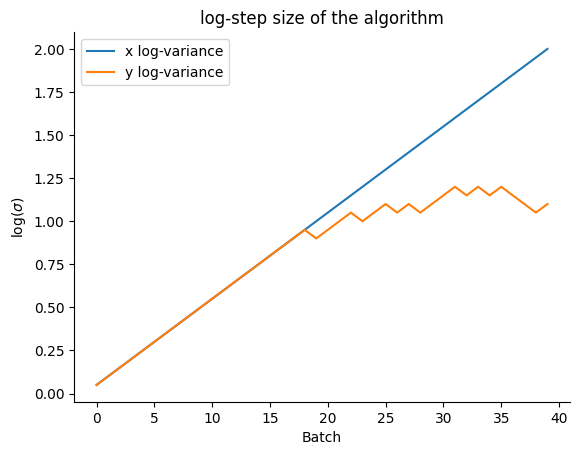

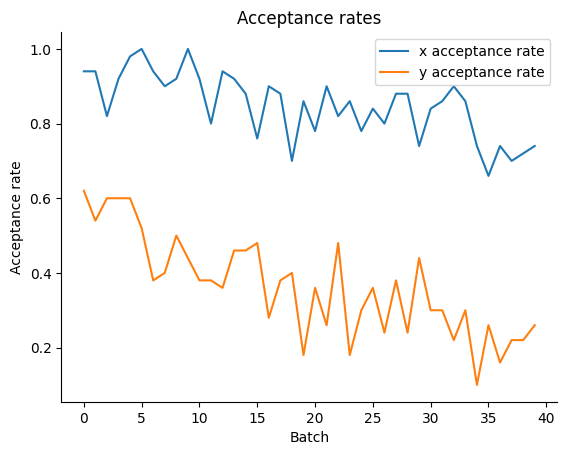

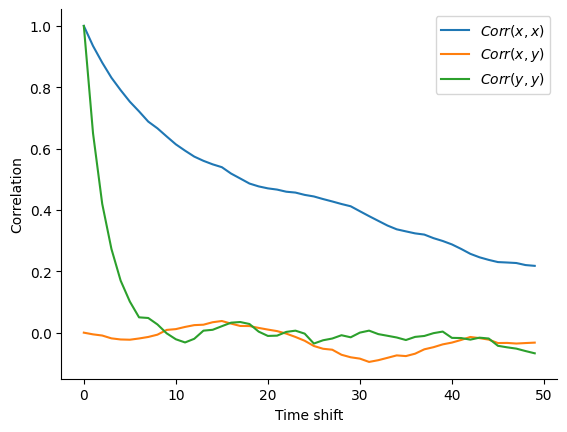

In [7]:
x_adapt, accepts, log_step_sizes = amhwg(log_pi, n_batches=40, batch_size=50, d=2)

scatter(x_adapt[:,0], x_adapt[:,1], alpha=0.3)

plt.figure()
plt.title('log-step size of the algorithm')
plt.plot(log_step_sizes[:,0], label='x log-variance')
plt.plot(log_step_sizes[:,1], label='y log-variance')
plt.xlabel('Batch')
plt.ylabel('$\log(\sigma)$')
plt.legend()
plt.show()

plt.figure()
plt.title('Acceptance rates')
plt.plot(accepts[:,0], label='x acceptance rate')
plt.plot(accepts[:,1], label='y acceptance rate')
plt.xlabel('Batch')
plt.ylabel('Acceptance rate')
plt.legend()
plt.show()

plt.figure()
plt.plot(cross_corr(x_adapt[:,0], x_adapt[:,0]), label='$Corr(x,x)$')
plt.plot(cross_corr(x_adapt[:,0], x_adapt[:,1]), label='$Corr(x,y)$')
plt.plot(cross_corr(x_adapt[:,1], x_adapt[:,1]), label='$Corr(y,y)$')
plt.xlabel('Time shift')
plt.ylabel('Correlation')
plt.legend()
plt.show()

We notice thta autocorrelation decreases faster in the adaptative version than the vanilla non corrected (with resêct to $\sigma$) version of the algorithm. However, it decreases slower than the corrected version of the first algorithm (but it's contextual).

#### 2. Testing on a banana-shaped density

(100, 100)


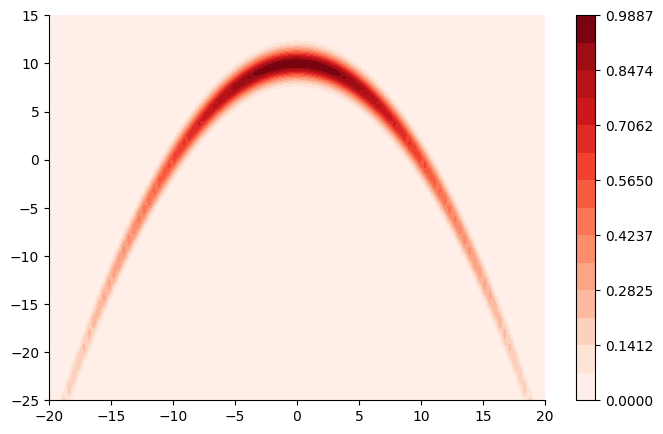

In [8]:
def log_b(x, B=0.1):
    x = x.copy()
    log_f = -x[0]**2/200 - 0.5*(x[1]+B*x[0]**2-100*B)**2 - 0.5*np.sum(x[2:]**2)
    return log_f

def b(x, B=0.1):
    f = np.exp(-x[0]**2/200 - 0.5*(x[1]+B*x[0]**2-100*B)**2)
    return f

plot_dist(b,
          xrange=np.linspace(-20,20,100),
          yrange=np.linspace(-25, 15,100),
          sidebar=True
         )

100%|██████████| 10000/10000 [01:13<00:00, 135.97it/s]


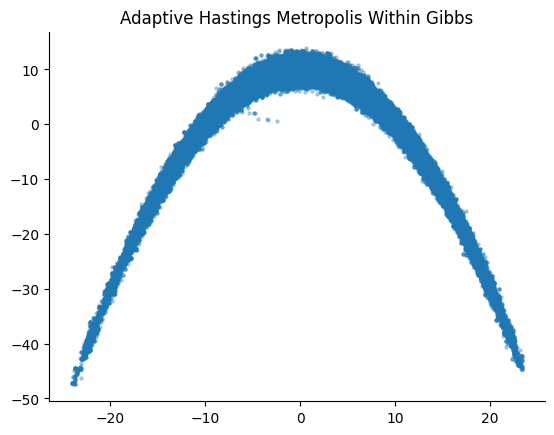

In [9]:
x_adapt, accepts, log_step_size = amhwg(log_b, n_batches=10_000, batch_size=30, d=20)
scatter(x_adapt[:,0],x_adapt[:,1], title='Adaptive Hastings Metropolis Within Gibbs')

## Exercice 2: Sampling from multimodal distributions

In [10]:
means = np.array([
    [2.18, 5.76],
    [8.67, 9.59],
    [4.24, 8.48],
    [8.41, 1.68],
    [3.93, 8.82],
    [3.25, 3.47],
    [1.70, 0.50],
    [4.59, 5.60],
    [6.91, 5.81],
    [6.87, 5.40],
    [5.41, 2.65],
    [2.70, 7.88],
    [4.98, 3.70],
    [1.14, 2.39],
    [8.33, 9.50],
    [4.93, 1.50],
    [1.83, 0.09],
    [2.26, 0.31],
    [5.54, 6.86],
    [1.69, 8.11]
])

std = 0.1

(200, 200)


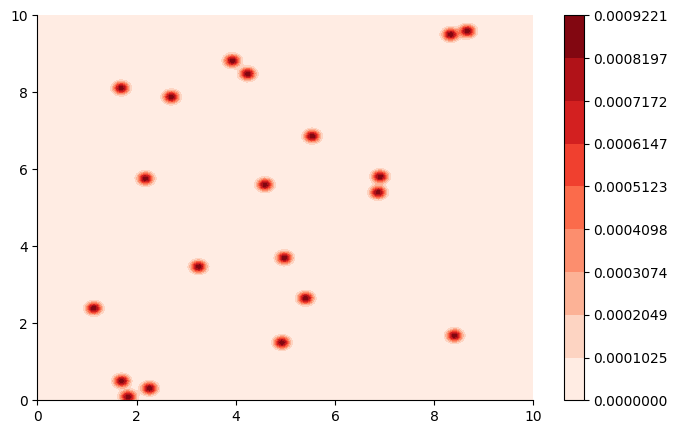

In [11]:
def logsumexp(a):
    a_max = np.max(a)
    return a_max + np.log(np.sum(np.exp(a - a_max)))

def log_gauss(x, mu, std):
    return -((x-mu)**2).sum(axis=-1)/(2*std**2)-1/(std*np.sqrt(2*np.pi))

def log_pi_gmm(x):
    log_pdfs = np.zeros((len(means), *x.shape[:-1]))
    for i in range(len(means)):
        log_pdfs[i] = log_gauss(x, means[i], std)
    log_pdf = logsumexp(log_pdfs)-np.log(len(means))
    return log_pdf

pi_gmm = lambda x : np.exp(log_pi_gmm(x))

plot_dist(pi_gmm,
          xrange=np.linspace(0,10,200),
          yrange=np.linspace(0,10,200),
          n_levels=10,
          sidebar=True
         )

#### 1. Implementation of Random Walk Hastings Metropolis

In [12]:
def rwmh(log_pi, n_iter, sigma_prop):
    """
    Implementation of Random Walk Hastings Metropolis
    """
    sigma_prop = np.array(sigma_prop)
    samples = np.zeros((n_iter, 2))
    x = np.random.randn(2)
    current_log_pi = log_pi(x)
    for i in tqdm(range(n_iter)):
        x_proposal = x + np.random.randn(2) * sigma_prop
        log_alpha = log_pi(x_proposal) - current_log_pi
        
        if np.log(np.random.rand()) < log_alpha:
            x = x_proposal
            current_log_pi = log_pi(x_proposal)
        samples[i] = x

    return samples

#### 2. Testing the algorithm

In [13]:
x = rwmh(log_pi_gmm, 5000, sigma_prop=[2,2])
x_adapt, accepts, L = amhwg(log_pi_gmm, n_batches=50, batch_size=100, d=2)

100%|██████████| 50/50 [00:01<00:00, 34.54it/s]


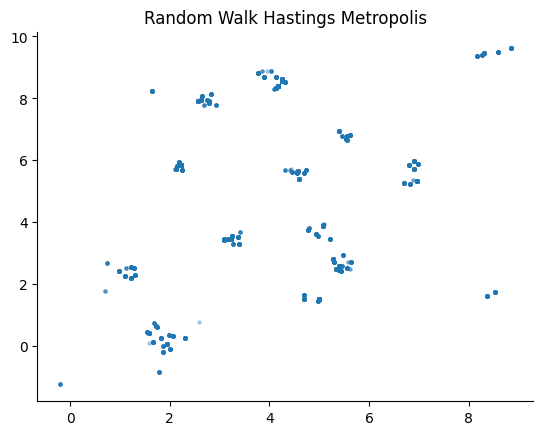

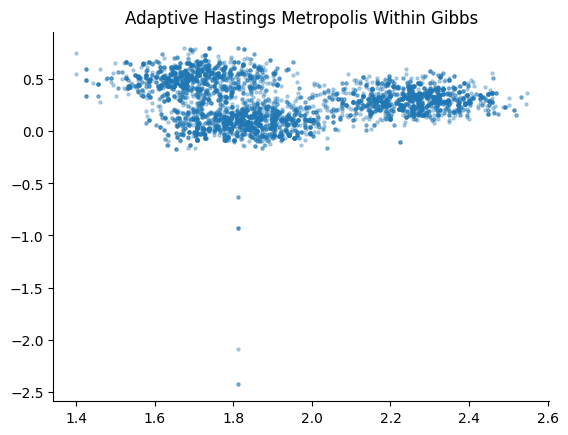

In [14]:
scatter(x[:,0],x[:,1], alpha=.3, title='Random Walk Hastings Metropolis')
scatter(x_adapt[:,0],x_adapt[:,1], alpha=.3, title='Adaptive Hastings Metropolis Within Gibbs')

**Observations**: Both algorithms fail to sample correctly from the target distribution. The Symmetric Random Walk Hastings Metropolis algorithm on the one hand, fails to sample evenly each Gaussians. On the other hand, the adaptative version isn't able to properly jump from one Gaussian to another.

### 2.B - Parallel Tempering

#### 1. Implementation of the algorithm

In [15]:
def parallel_tempering(log_pi, temps, n_iter, sigma_prop=[1,1]):
    K = len(temps)
    accepts = np.zeros(K)
    jumps = 0
    sigma_prop = np.array(sigma_prop)
    X = np.random.randn(K, 2)
    samples = np.zeros((n_iter, K, 2))
    current_log_pi = [log_pi(x) / T for T, x in zip(temps, X)] # (K, 2)

    for it in tqdm(range(n_iter)):
        for k, T in enumerate(temps):
            y = X[k] + np.random.randn(2) * sigma_prop * 0.25 * np.sqrt(T)
            new_log_pi = log_pi(y) / T
            log_alpha = new_log_pi - current_log_pi[k]
            if np.log(np.random.rand()) < log_alpha:
                X[k] = y
                current_log_pi[k] = new_log_pi
                accepts[k] +=1

        # Swap
        i, j = np.random.choice(np.arange(K), size=2, replace=False)
        log_alpha = log_pi(X[i]) / temps[j] + log_pi(X[j]) / temps[i] - log_pi(X[i]) / temps[i] - log_pi(X[j] ) / temps[j]
        if np.log(np.random.rand()) < log_alpha:
            X[i], X[j] = X[j], X[i]
            jumps += 1

        samples[it] = X
    print(f'Acceptance rate {accepts/n_iter}')
    print(f'Jump rate {jumps/n_iter}')
    return samples

#### 2. Testing the algorithm

In [16]:
temps = [60, 21.5, 7.7, 2.8, 1.0]
x = parallel_tempering(log_pi_gmm, temps=temps, n_iter=20000)

100%|██████████| 20000/20000 [00:19<00:00, 1009.17it/s]

Acceptance rate [0.50975 0.39475 0.2836  0.25635 0.2534 ]
Jump rate 0.3447


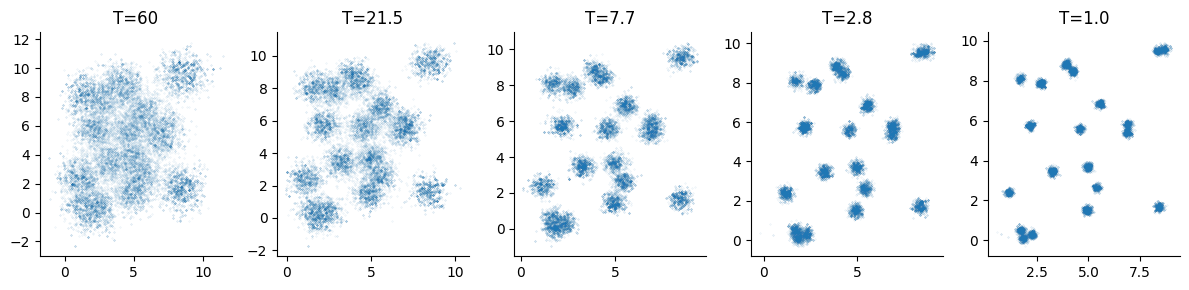

In [17]:
n_temps = len(temps)
fix, axes = plt.subplots(1, n_temps, figsize=(12, 3))
for i, (ax, T) in enumerate(zip(axes, temps)):
    ax.scatter(x[:, i, 0], x[:, i, 1], alpha=0.2, s=0.05)
    ax.set_title(f'T={T}')
plt.tight_layout()

## Exercise 3: Bayesian analysis of a one-way random effects model

#### 1. Posterior distribution

The prior is given by:

$$\pi_{\text{prior}}(\mu, \sigma^2, \tau^2) \propto \frac{1}{\sigma^{2(1+\alpha)}} \exp\left(-\frac{\beta}{\sigma^2}\right) \frac{1}{\tau^{2(1+\gamma)}} \exp\left(-\frac{\beta}{\tau^2}\right)
$$

By definition we have:

\begin{align}
\pi_{\text{posterior}}(X, Y, \mu, \sigma^2, \tau^2) & \propto \pi(X, Y \mid \mu, \sigma^2, \tau^2) \cdot \pi_{\text{prior}}(\mu, \sigma^2, \tau^2) \\
& \propto \pi(Y \mid X, \mu, \sigma^2, \tau^2) \cdot \pi(X \mid \mu, \sigma^2, \tau^2) \cdot \pi_{\text{prior}}(\mu, \sigma^2, \tau^2)
\end{align}

with:

$$\pi(Y \mid X, \mu, \sigma^2, \tau^2) \propto \frac{1}{\tau^{Nk}}\exp\left(-\frac{1}{2\tau^2} \sum_{ij} (y_{ij} - x_i)^2\right) \hspace{20pt} X\text{ is known thus deterministic. So it follows the distribution of } \epsilon$$

$$\pi(X \mid \mu, \sigma^2, \tau^2) \propto\frac{1}{\sigma^{N}} \exp\left(-\frac{1}{2\sigma^2} \sum_{i} (x_{i} - \mu)^2\right)$$

Finally, by re-arranging the terms together we get:

$$\pi_{\text{posterior}}(X, Y, \mu, \sigma^2, \tau^2) \propto \frac{1}{\sigma^{2(1+\alpha) + N}} \exp\left(-\frac{1}{\sigma^2}\left[\beta + \frac{1}{2} \sum_{i} (x_{i} - \mu)^2 \right] \right) \frac{1}{\tau^{2(1+\gamma) + Nk}} \exp\left(-\frac{1}{\tau^2} \left[\beta + \frac{1}{2} \sum_{ij} (y_{ij} - x_i)^2 \right]\right)$$

#### 2. Gibbs sampler

From the expression of the posterior distribution, we derive the conditional distributions of $(\sigma^2, \tau^2, \mu, X)$:

- Conditional of $X_i, i \in [\![1, N]\!]$:
  $$X_i \mid \mu, \sigma^2, \tau^2, Y \sim \mathcal{N}\biggl(\frac{\frac{\mu}{\sigma^2} + \frac{k_i \bar{y}_i}{\tau^2}}{\frac{1}{\sigma^2} + \frac{k_i}{\tau^2}}, \biggl(\frac{1}{\sigma^2} + \frac{k_i}{\tau^2}\biggr)^{-1}\biggr)
$$
where $\bar{y_i}=\frac{1}{k_i}\sum_{j=1}^{k_i}y_{ij}$

- Conditional of $\mu$:

$$\mu \mid X, \sigma^2, \tau^2, Y \sim \mathcal{N}\biggl(\overline{X}, \frac{\sigma^2}{N}\biggr)$$
where $\bar{X}=\frac{1}{N}\sum_{i=1}^N X_i$

- Conditional of $\sigma^2$:

$$\sigma^2 \mid \mu, X, \tau^2, Y \sim \text{Inverse-Gamma}\biggl(\alpha + 1 + \frac{N}{2}, \ \beta + \frac{1}{2}\sum_{i=1}^N (X_i - \mu)^2\biggr)$$

- Conditional of $\tau^2$:

$$\tau^2 \mid \mu, X, \sigma^2, Y \sim \text{Inverse-Gamma}\biggl(\gamma + 1 + \frac{n}{2}, \ \beta + \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^{k_i}(y_{i,j} - X_i)^2\biggr)$$

In [18]:
def gibbs_sampler(Y, alpha, beta, gamma, n_iter=10000):
    N = len(Y)
    k = np.array([len(y_i) for y_i in Y])
    n = np.sum(k)
    
    mu = np.mean([np.mean(y_i) for y_i in Y])
    X = np.array([np.mean(y_i) for y_i in Y])
    sigma2 = np.var(X - mu) if np.var(X - mu) > 0 else 1.0
    tau2 = np.var(np.concatenate(Y) - np.repeat(X, k)) if np.var(np.concatenate(Y) - np.repeat(X, k)) > 0 else 1.0
    
    mu_chain = np.zeros(n_iter)
    X_chain = np.zeros((n_iter, N))
    sigma2_chain = np.zeros(n_iter)
    tau2_chain = np.zeros(n_iter)
    
    for t in range(n_iter):
        X_mean = np.mean(X)
        mu_mean = X_mean
        mu_var = sigma2 / N
        mu = norm.rvs(loc=mu_mean, scale=np.sqrt(mu_var))

        # Update X
        for i in range(N):
            ki = k[i]
            y_i = Y[i]
            y_mean = np.mean(y_i)
            denom = (1.0/sigma2 + ki/tau2)
            X_mean_i = ( (mu/sigma2) + (ki*y_mean/tau2) ) / denom
            X_var_i = 1.0 / denom
            X[i] = norm.rvs(loc=X_mean_i, scale=np.sqrt(X_var_i))
        
        # Update sigma2
        shape_sigma = alpha + 1 + N/2.0
        scale_sigma = beta + 0.5 * np.sum((X - mu)**2)
        sigma2 = invgamma.rvs(a=shape_sigma, scale=scale_sigma)
        
        # Update tau2
        resid_sum = 0.0
        for i in range(N):
            resid_sum += np.sum((Y[i] - X[i])**2)
        shape_tau = gamma + 1 + n/2.0
        scale_tau = beta + 0.5 * resid_sum
        tau2 = invgamma.rvs(a=shape_tau, scale=scale_tau)
        
        # Store samples
        mu_chain[t] = mu
        X_chain[t, :] = X
        sigma2_chain[t] = sigma2
        tau2_chain[t] = tau2
    
    return mu_chain, X_chain, sigma2_chain, tau2_chain


#### 3. Implementation of the Block-Gibbs sampler

In [19]:
def block_gibbs_sampler(Y, alpha, beta, gamma, n_iter=10000):
    N = len(Y)
    k = np.array([len(y_i) for y_i in Y])
    n = np.sum(k)
    Ybar = np.array([np.mean(y_i) for y_i in Y])
    
    mu = np.mean(Ybar)
    X = Ybar.copy()  # initial guess
    # Ensure non-zero variance for initial sigma2 and tau2
    sigma2 = np.var(X - mu) if np.var(X - mu) > 0 else 1.0
    resid = np.concatenate([y_i - X[i] for i, y_i in enumerate(Y)])
    tau2 = np.var(resid) if np.var(resid) > 0 else 1.0
    
    mu_chain = np.zeros(n_iter)
    X_chain = np.zeros((n_iter, N))
    sigma2_chain = np.zeros(n_iter)
    tau2_chain = np.zeros(n_iter)
    
    for t in range(n_iter):
        # Update (X, mu)
        Q = np.zeros((N+1, N+1))
        b = np.zeros(N+1)
        
        for i in range(N):
            Q[i,i] = (k[i]/tau2) + (1.0/sigma2)
            Q[i,N] = Q[N,i] = -1.0/sigma2
            b[i] = (k[i]/tau2)*Ybar[i]
        
        Q[N,N] = N/sigma2
        b[N] = 0.0
        
        mean = np.linalg.solve(Q, b)        
        L = np.linalg.cholesky(Q)
        
        z = np.random.randn(N+1)

        y = np.linalg.solve(L, z)
        Xmu_sample = mean + y
        
        X = Xmu_sample[:N]
        mu = Xmu_sample[N]
        
        # Update sigma2
        shape_sigma = alpha + 1.0 + N/2.0
        scale_sigma = beta + 0.5 * np.sum((X - mu)**2)
        sigma2 = invgamma.rvs(a=shape_sigma, scale=scale_sigma)
        
        # Update tau2
        resid_sum = 0.0
        for i in range(N):
            resid_sum += np.sum((Y[i] - X[i])**2)
        shape_tau = gamma + 1.0 + n/2.0
        scale_tau = beta + 0.5 * resid_sum
        tau2 = invgamma.rvs(a=shape_tau, scale=scale_tau)
        
        mu_chain[t] = mu
        X_chain[t,:] = X
        sigma2_chain[t] = sigma2
        tau2_chain[t] = tau2
    
    return mu_chain, X_chain, sigma2_chain, tau2_chain


#### 4. Theoretical performances

**Autocorrelation**: $X$ is drawn from mean $\mu$ so both variables are correlated. This limits the exploration capabilities of the Markov chain at stake. Sampling $X$ and $\mu$ jointly reduces this correlation, thus improving mixing and producing more independent samples faster.

**Computational efficiency**: One the one hand, sampling jointly $X$ and $\mu$ is computationally relatively expensive because we need to solve a linear system and perform a cholecky facorization. On the other hand, since block sampling encourages faster mixing, it requires fewer iterations to provide independent samples than the first version of the Gibbs sampler.

In [20]:
def generate_data(N, k, mu_true, sigma2_true, tau2_true):
    X_true = norm.rvs(loc=mu_true, scale=np.sqrt(sigma2_true), size=N)
    Y = []
    for i in range(N):
        y_i = norm.rvs(loc=X_true[i], scale=np.sqrt(tau2_true), size=k)
        Y.append(y_i)
    return Y, X_true

# Example parameters
N = 10      # number of groups
k = 5       # observations per group
mu_true = 2.0
sigma2_true = 1.0
tau2_true = 0.5

# Hyperparameters for priors
alpha = 1.0
beta = 1.0
gamma = 1.0

Y, X_true = generate_data(N, k, mu_true, sigma2_true, tau2_true)

mu_chain_1, X_chain_1, sigma2_chain_1, tau2_chain_1 = gibbs_sampler(Y, alpha, beta, gamma, n_iter=20000)
mu_chain_2, X_chain_2, sigma2_chain_2, tau2_chain_2 = block_gibbs_sampler(Y, alpha, beta, gamma, n_iter=20000)

# Discard burn-in
burn_in = 5000
mu_chain_1 = mu_chain_1[burn_in:]
X_chain_1 = X_chain_1[burn_in:]
sigma2_chain_1 = sigma2_chain_1[burn_in:]
tau2_chain_1 = tau2_chain_1[burn_in:]

mu_chain_2 = mu_chain_2[burn_in:]
X_chain_2 = X_chain_2[burn_in:]
sigma2_chain_2 = sigma2_chain_2[burn_in:]
tau2_chain_2 = tau2_chain_2[burn_in:]

# Compute posterior means
mu_est_1 = np.mean(mu_chain_1)
sigma2_est_1 = np.mean(sigma2_chain_1)
tau2_est_1 = np.mean(tau2_chain_1)
X_est_1 = np.mean(X_chain_1, axis=0)

mu_est_2 = np.mean(mu_chain_2)
sigma2_est_2 = np.mean(sigma2_chain_2)
tau2_est_2 = np.mean(tau2_chain_2)
X_est_2 = np.mean(X_chain_2, axis=0)

# Print results
print('True parameters:')
print(f'mu_true = {mu_true}, sigma2_true = {sigma2_true}, tau2_true = {tau2_true}')

print('\nGibbs estimates:')
print(f'mu_est = {mu_est_1:.3f}, sigma2_est = {sigma2_est_1:.3f}, tau2_est = {tau2_est_1:.3f}')

print('First 5 true X_i vs estimated X_i:')
for i in range(min(5, N)):
    print(f'X_true[{i}] = {X_true[i]:.3f}, X_est[{i}] = {X_est_1[i]:.3f}')

print('\nBlock Gibbs estimates:')
print(f'mu_est = {mu_est_2:.3f}, sigma2_est = {sigma2_est_2:.3f}, tau2_est = {tau2_est_2:.3f}')

print('First 5 true X_i vs estimated X_i (block):')
for i in range(min(5, N)):
    print(f'X_true[{i}] = {X_true[i]:.3f}, X_est[{i}] = {X_est_2[i]:.3f}')

True parameters:
mu_true = 2.0, sigma2_true = 1.0, tau2_true = 0.5

Gibbs estimates:
mu_est = 2.471, sigma2_est = 0.963, tau2_est = 0.425
First 5 true X_i vs estimated X_i:
X_true[0] = 2.319, X_est[0] = 2.160
X_true[1] = 3.434, X_est[1] = 3.072
X_true[2] = 2.472, X_est[2] = 2.310
X_true[3] = 1.085, X_est[3] = 1.183
X_true[4] = 1.932, X_est[4] = 1.953

Block Gibbs estimates:
mu_est = 2.469, sigma2_est = 0.969, tau2_est = 0.421
First 5 true X_i vs estimated X_i (block):
X_true[0] = 2.319, X_est[0] = 2.160
X_true[1] = 3.434, X_est[1] = 3.075
X_true[2] = 2.472, X_est[2] = 2.315
X_true[3] = 1.085, X_est[3] = 1.183
X_true[4] = 1.932, X_est[4] = 1.953
